<a href="https://colab.research.google.com/github/runtorain/GenerativeDeepLearning/blob/main/AutoRegressiveMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://raw.githubusercontent.com/LukeDitria/pytorch_tutorials/671863362869b526ffc1022a5a1f393e8d6dbac1/section12_sequential/data/weather.csv

Downloading...
From: https://raw.githubusercontent.com/LukeDitria/pytorch_tutorials/671863362869b526ffc1022a5a1f393e8d6dbac1/section12_sequential/data/weather.csv
To: /content/weather.csv
78.7kB [00:00, 75.1MB/s]       


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F


In [3]:
df = pd.read_csv("/content/weather.csv")
df.head()

,Date,Rainfall amount (millimetres),Maximum temperature (Degree C)
0,2013-06-02,5.0,15.7
1,2013-06-03,0.2,14.8
2,2013-06-04,0.2,15.0
3,2013-06-05,0.0,14.6
4,2013-06-06,0.0,17.3


In [44]:
import pandas as pd

import torch
from torch.utils.data.dataset import Dataset

class WeatherDataset(Dataset):
    def __init__(self, dataset_file, day_range, split_date, train_test="train"):
        df = pd.read_csv(dataset_file)
        df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
        df.set_index('Date', inplace=True)

        # Calculate the mean and std to normalise the data
        mean = df.mean()
        std = df.std()
        df = (df - mean) / std

        self.mean = torch.tensor(mean.to_numpy()).reshape(1, -1)
        self.std = torch.tensor(std.to_numpy()).reshape(1, -1)

        # Split the dataset to test/train set based on a split date
        if train_test == "train":
            self.dataset = df[df.index < split_date]
        elif train_test == "test":
            self.dataset = df[df.index >= split_date]
        else:
            ValueError("train_test should be train or test")

        self.day_range = day_range

    def __getitem__(self, index):
        # Index a range of days
        end_index = index + self.day_range
        current_series = self.dataset.iloc[index:end_index]

        day_tensor = torch.LongTensor(current_series.index.day.to_numpy())
        month_tensor = torch.LongTensor(current_series.index.month.to_numpy())
        data_values = torch.FloatTensor(current_series.values)

        return day_tensor, month_tensor, data_values

    def __len__(self):
        return len(self.dataset) - self.day_range

In [45]:
# Path to the CSV file containing the weather dataset
dataset_file = "/content/weather.csv"

# Define the date to split the dataset into training and testing sets
split_date = pd.to_datetime('2023-01-01')

# Number of days in the input sequence
day_range = 15

# Number of days the MLP will take as input
days_in = 14

# Ensure that the total number of days in the input sequence is larger than the MLP input size
assert day_range > days_in, "The total day range must be larger than the input days for the MLP"

# Define the hyperparameters for training the model
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 500  # Number of training epochs
batch_size = 32  # Batch size for training

# Create training dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data before split_date is used for training
dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")

# Create testing dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data after split_date is used for testing
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")

In [46]:
dataset_test[0]

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([[-0.3595,  2.5729],
         [ 1.0957,  1.9271],
         [-0.3140,  0.1220],
         [-0.3595, -0.2755],
         [-0.1321,  0.2048],
         [-0.3595,  0.8672],
         [-0.3595,  1.6290],
         [-0.3595,  1.9105],
         [-0.3595,  0.9666],
         [-0.3595,  0.2048],
         [-0.3595,  1.5793],
         [-0.3595,  0.6022],
         [-0.3595,  0.6354],
         [-0.3595,  2.8545],
         [-0.3595,  0.0392]]))

In [47]:
dataset_test.mean

tensor([[ 1.5811, 20.3634]], dtype=torch.float64)

In [48]:
dataset_test.std

tensor([[4.3982, 6.0385]], dtype=torch.float64)

In [49]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

Number of training examples: 3480
Number of testing examples: 412


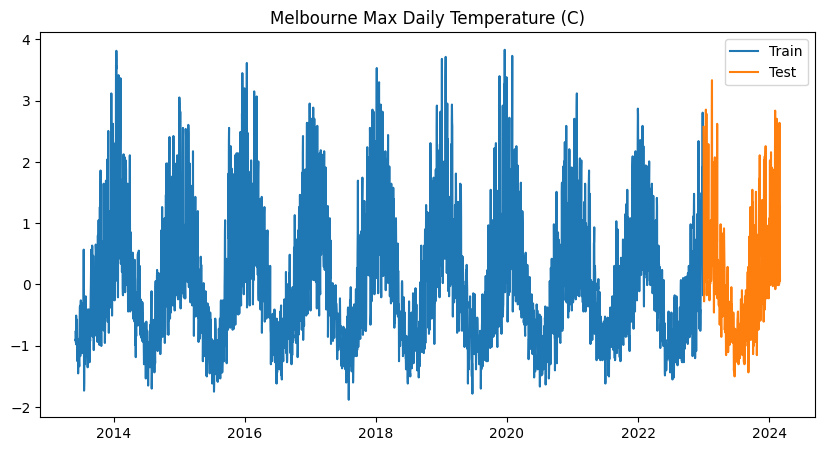

In [50]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])
# Note:see here how we can just directly access the data from the dataset class

In [51]:
# Define a residual MLP block
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(input_size)
        # First fully connected layer that reduces the dimensionality by half
        self.fc1 = nn.Linear(input_size, input_size // 2)

        # Layer normalization after the first fully connected layer
        self.norm2 = nn.LayerNorm(input_size // 2)
        # Second fully connected layer that outputs the desired output size
        self.fc2 = nn.Linear(input_size // 2, output_size)

        # Skip connection layer to match the output size
        self.fc3 = nn.Linear(input_size, output_size)

        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply normalization and activation function to the input
        x = self.act(self.norm1(x))
        # Compute the skip connection output
        skip = self.fc3(x)

        # Apply the first fully connected layer, normalization, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        # Apply the second fully connected layer
        x = self.fc2(x)

        # Add the skip connection to the output
        return x + skip


class ResMLP(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1):
        super(ResMLP, self).__init__()

        # Compute the length of the sequence data
        seq_data_len = seq_len * 2

        # Define the input MLP with two fully connected layers and normalization
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),
            nn.LayerNorm(4 * seq_data_len),
            nn.Linear(4 * seq_data_len, 128)
        )

        # Define the sequence of residual blocks
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)

        # Final output fully connected layer
        self.fc_out = nn.Linear(128, output_size)
        # Activation function
        self.act = nn.ELU()

    def forward(self, input_seq):
        # Reshape the input sequence to be a flat vector
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        # Pass the input through the input MLP
        input_vec = self.input_mlp(input_seq)

        # Pass the output through the residual blocks and activation function
        x = self.act(self.res_blocks(input_vec))

        # Compute the final output
        return self.fc_out(x)

In [52]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Create an instance of the ResMLP model
# - seq_len is the number of days the model takes as input (days_in)
# - output_size is the number of outputs the model predicts (2: Max Daily Temperature and Rainfall)
weather_mlp = ResMLP(seq_len=days_in, output_size=2).to(device)

# Initialize the optimizer
# - Use Adam optimizer which is an adaptive learning rate optimization algorithm
# - It updates the weights of the model based on the computed gradients
# - weather_mlp.parameters() returns all the parameters of the model
# - lr is the learning rate, which controls how much to change the model in response to the estimated error
optimizer = optim.Adam(weather_mlp.parameters(), lr=learning_rate)

# Define the loss function
# - Mean Squared Error (MSE) is used as the loss function
# - MSE calculates the average of the squares of the errors (differences between predicted and actual values)
loss_fn = nn.MSELoss()

# Initialize a list to log the training loss over epochs
training_loss_logger = []

In [53]:
from torchsummary import summary

# Print the model summary
summary(weather_mlp, input_size=(days_in, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 112]           3,248
               ELU-2                  [-1, 112]               0
         LayerNorm-3                  [-1, 112]             224
            Linear-4                  [-1, 128]          14,464
         LayerNorm-5                  [-1, 128]             256
               ELU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
            Linear-8                   [-1, 64]           8,256
         LayerNorm-9                   [-1, 64]             128
              ELU-10                   [-1, 64]               0
           Linear-11                  [-1, 128]           8,320
      ResBlockMLP-12                  [-1, 128]               0
              ELU-13                  [-1, 128]               0
           Linear-14                   

In [54]:
print(weather_mlp)

ResMLP(
  (input_mlp): Sequential(
    (0): Linear(in_features=28, out_features=112, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=112, out_features=128, bias=True)
  )
  (res_blocks): Sequential(
    (0): ResBlockMLP(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=128, out_features=64, bias=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (fc3): Linear(in_features=128, out_features=128, bias=True)
      (act): ELU(alpha=1.0)
    )
  )
  (fc_out): Linear(in_features=128, out_features=2, bias=True)
  (act): ELU(alpha=1.0)
)


In [55]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in weather_mlp.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 51666 (Approximately 0 Million) Parameters!


In [57]:
# Iterate over the number of epochs
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_mlp.train()

    # Iterate over the training data loader
    for day, month, data_seq in data_loader_train:

        # Extract the initial sequence block to be used as input for the model
        seq_block = data_seq[:, :days_in].to(device)

        # Initialize the loss for the current batch
        loss = 0

        # Iterate over the remaining sequence to predict the next day values
        for i in range(day_range - days_in):
            # Get the target sequence block for the next day
            target_seq_block = data_seq[:, i + days_in].to(device)

            # Make predictions using the model
            data_pred = weather_mlp(seq_block)

            # Accumulate the loss for the current prediction
            loss += loss_fn(data_pred, target_seq_block)

            # Update the input sequence by removing the oldest date and adding the new prediction
            # Detach the new sequence to prevent backpropagation through the old sequence
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1).detach()

        # Average the accumulated loss over the number of steps
        loss /= i + 1

        # Zero the gradients before performing backpropagation
        optimizer.zero_grad()

        # Perform backpropagation to compute gradients
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Log the training loss for later analysis
        training_loss_logger.append(loss.item())

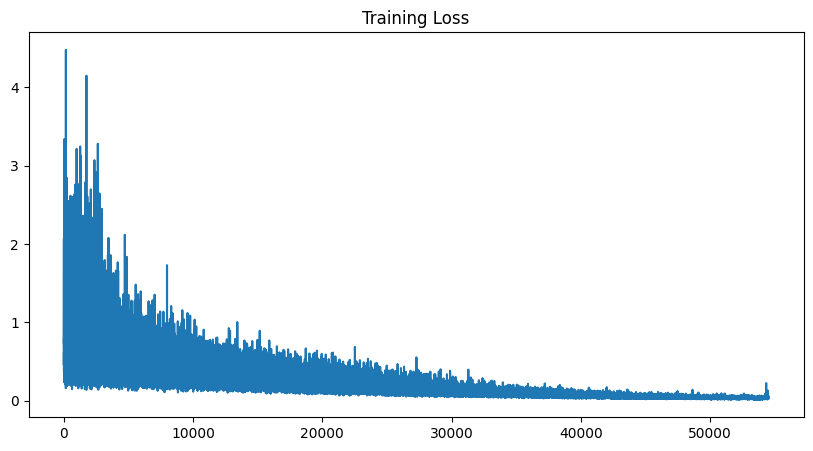

In [58]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [59]:
# Convert the test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize a list to log predictions
log_predictions = []

# Set the model to evaluation mode
weather_mlp.eval()

# Disable gradient calculation for the prediction process
with torch.no_grad():
    # Extract the initial sequence block to be used as input for the model
    # - unsqueeze(0) adds a batch dimension to the input
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)

    # Iterate over the sequence to predict the next day values
    for i in range(data_tensor.shape[0] - days_in):
        # Make predictions using the model
        data_pred = weather_mlp(seq_block)

        # Log the prediction
        log_predictions.append(data_pred.cpu())

        # Update the input sequence by removing the oldest date and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions using the dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean

# Unnormalize the original data using the dataset's standard deviation and mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

# Trim the initial sequence from the unnormalized data to match the length of predictions
un_norm_data = un_norm_data[days_in:]

In [60]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 44.68


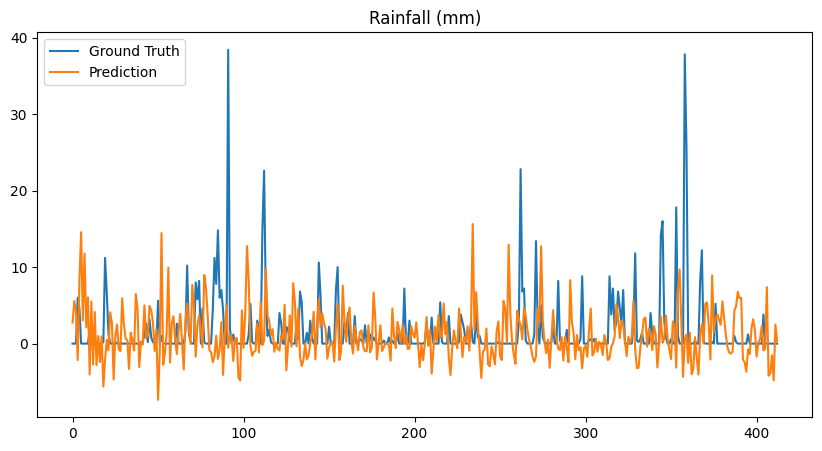

In [61]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

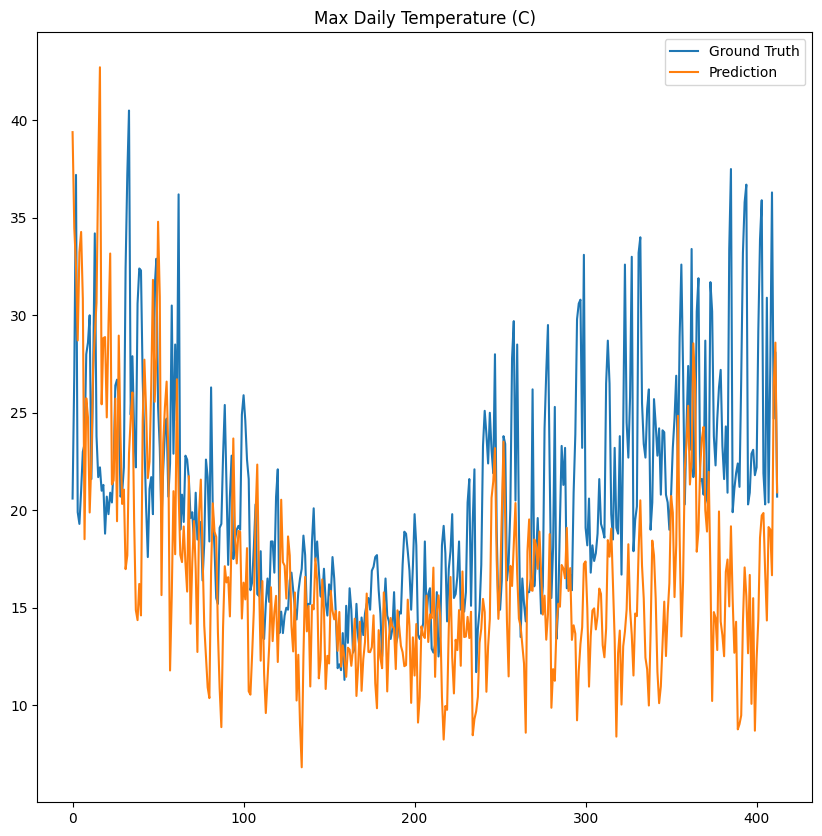

In [62]:
_ = plt.figure(figsize=(10, 10))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])

##Modify for in 30 Day and out 7 Day

In [17]:
# Define a residual MLP block
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(input_size)
        # First fully connected layer that reduces the dimensionality by half
        self.fc1 = nn.Linear(input_size, input_size // 2)

        # Layer normalization after the first fully connected layer
        self.norm2 = nn.LayerNorm(input_size // 2)
        # Second fully connected layer that outputs the desired output size
        self.fc2 = nn.Linear(input_size // 2, output_size)

        # Skip connection layer to match the output size
        self.fc3 = nn.Linear(input_size, output_size)

        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply normalization and activation function to the input
        x = self.act(self.norm1(x))
        # Compute the skip connection output
        skip = self.fc3(x)

        # Apply the first fully connected layer, normalization, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        # Apply the second fully connected layer
        x = self.fc2(x)

        # Add the skip connection to the output
        return x + skip

class ResMLP(nn.Module):
    def __init__(self, seq_len, output_days, output_features, num_blocks=1):
        super(ResMLP, self).__init__()

        # Compute the input feature size (seq_len * features per day)
        input_size = seq_len * 2  # Assuming 2 features per day

        # Define the input MLP with two fully connected layers and normalization
        self.input_mlp = nn.Sequential(
            nn.Linear(input_size, 4 * input_size),
            nn.ELU(),
            nn.LayerNorm(4 * input_size),
            nn.Linear(4 * input_size, 128)
        )

        # Define the sequence of residual blocks
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)

        # Final output fully connected layer
        self.fc_out = nn.Linear(128, output_days * output_features)  # Predict 7 days × features
        # Activation function
        self.act = nn.ELU()

    def forward(self, input_seq):
        # Reshape the input sequence to be a flat vector
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        # Pass the input through the input MLP
        input_vec = self.input_mlp(input_seq)

        # Pass the output through the residual blocks and activation function
        x = self.act(self.res_blocks(input_vec))

        # Compute the final output
        return self.fc_out(x).reshape(input_seq.shape[0], -1, 2)  # Reshape to (batch_size, 7, 2)


In [18]:
# Define the model
seq_len = 30  # 30 days of input
output_days = 7  # Predict 7 days
output_features = 2  # Features per day (e.g., temperature, rainfall)
weather_mlp = ResMLP(seq_len=seq_len, output_days=output_days, output_features=output_features).to(device)


In [19]:
# Print the model summary
from torchsummary import summary
summary(weather_mlp, input_size=(seq_len, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 240]          14,640
               ELU-2                  [-1, 240]               0
         LayerNorm-3                  [-1, 240]             480
            Linear-4                  [-1, 128]          30,848
         LayerNorm-5                  [-1, 128]             256
               ELU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
            Linear-8                   [-1, 64]           8,256
         LayerNorm-9                   [-1, 64]             128
              ELU-10                   [-1, 64]               0
           Linear-11                  [-1, 128]           8,320
      ResBlockMLP-12                  [-1, 128]               0
              ELU-13                  [-1, 128]               0
           Linear-14                   

In [20]:
class WeatherDataset(Dataset):
    def __init__(self, dataset_file, input_days, output_days, split_date, train_test="train"):
        df = pd.read_csv(dataset_file)
        df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
        df.set_index('Date', inplace=True)

        # Normalize the data using mean and std
        mean = df.mean()
        std = df.std()
        df = (df - mean) / std

        self.mean = torch.tensor(mean.to_numpy()).reshape(1, -1)
        self.std = torch.tensor(std.to_numpy()).reshape(1, -1)

        # Split the dataset into train/test sets
        if train_test == "train":
            self.dataset = df[df.index < split_date]
        elif train_test == "test":
            self.dataset = df[df.index >= split_date]
        else:
            raise ValueError("train_test should be 'train' or 'test'")

        self.input_days = input_days
        self.output_days = output_days

    def __getitem__(self, index):
        # Extract input and output sequences
        input_end_index = index + self.input_days
        output_end_index = input_end_index + self.output_days

        # Input sequence (30 days)
        input_series = self.dataset.iloc[index:input_end_index]

        # Output sequence (7 days)
        output_series = self.dataset.iloc[input_end_index:output_end_index]

        # Convert dates to tensors
        input_day_tensor = torch.LongTensor(input_series.index.day.to_numpy())
        input_month_tensor = torch.LongTensor(input_series.index.month.to_numpy())
        input_values = torch.FloatTensor(input_series.values)

        output_values = torch.FloatTensor(output_series.values)

        return input_day_tensor, input_month_tensor, input_values, output_values

    def __len__(self):
        return len(self.dataset) - (self.input_days + self.output_days) + 1


In [21]:
# Define parameters
input_days = 30  # Number of input days
output_days = 7  # Number of days to predict
split_date = pd.to_datetime('2023-01-01')

# Initialize datasets
dataset_train = WeatherDataset(
    dataset_file=dataset_file,
    input_days=input_days,
    output_days=output_days,
    split_date=split_date,
    train_test="train"
)

dataset_test = WeatherDataset(
    dataset_file=dataset_file,
    input_days=input_days,
    output_days=output_days,
    split_date=split_date,
    train_test="test"
)

# Example: Accessing a sample
input_day_tensor, input_month_tensor, input_values, output_values = dataset_train[0]
print("Input Days Shape:", input_values.shape)  # Should be (30, features)
print("Output Days Shape:", output_values.shape)  # Should be (7, features)


Input Days Shape: torch.Size([30, 2])
Output Days Shape: torch.Size([7, 2])


In [22]:
dataset_train[0]

(tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  1]),
 tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 7]),
 tensor([[ 0.7774, -0.7723],
         [-0.3140, -0.9213],
         [-0.3140, -0.8882],
         [-0.3595, -0.9545],
         [-0.3595, -0.5073],
         [ 2.5963, -0.9710],
         [-0.2231, -0.7723],
         [-0.3595, -0.9876],
         [-0.3595, -0.5736],
         [-0.3595, -0.9213],
         [-0.3140, -1.1697],
         [ 1.8232, -1.2525],
         [ 1.7323, -1.0869],
         [-0.3595, -1.0207],
         [-0.2231, -1.0373],
         [-0.1321, -1.4513],
         [ 0.0952, -0.9213],
         [-0.3595, -1.0373],
         [-0.3595, -0.9048],
         [-0.3595, -0.8882],
         [-0.3595, -1.2691],
         [-0.3595, -1.3353],
         [-0.3595, -1.3353],
         [-0.3595, -0.6564],
         [-0.3595, -0.4576],
         [-0.3595, -0.358

In [23]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)


Number of training examples: 3459
Number of testing examples: 391


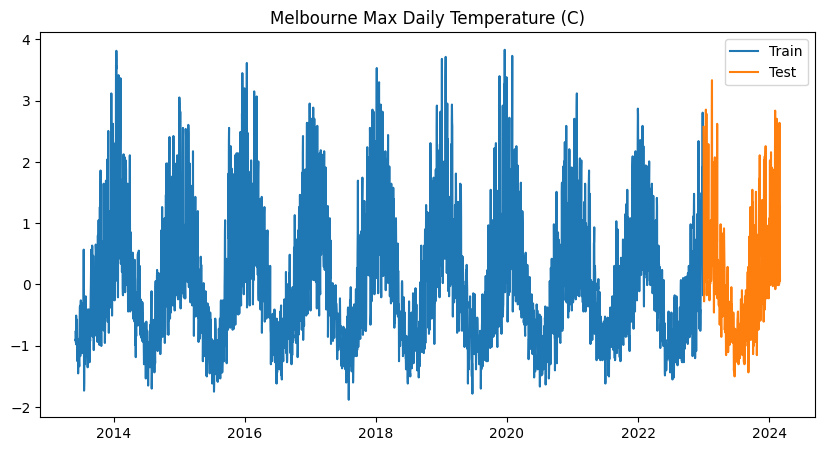

In [24]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])
# Note:see here how we can just directly access the data from the dataset class

In [25]:
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

# Training loop
training_loss_logger = []

for epoch in trange(nepochs, desc="Epochs", leave=False):
    weather_mlp.train()
    epoch_loss = 0  # Initialize loss for the epoch

    for day, month, data_seq, target_seq in data_loader_train:
        # Move data to the device (GPU/CPU)
        seq_block = data_seq.to(device)  # (batch_size, 30, features)
        target_seq_block = target_seq.to(device)  # (batch_size, 7, features)

        # Make predictions
        data_pred = weather_mlp(seq_block)  # (batch_size, 7, features)

        # Calculate the loss between predictions and targets
        loss = loss_fn(data_pred, target_seq_block)

        # Zero the gradients, backpropagate, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss for this batch
        epoch_loss += loss.item()

    # Log the average loss for the epoch
    avg_loss = epoch_loss / len(data_loader_train)
    training_loss_logger.append(avg_loss)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{nepochs}, Loss: {avg_loss:.4f}")




Epochs:   2%|▏         | 10/500 [00:14<11:04,  1.36s/it]

Epoch 10/500, Loss: 1.2136


Epochs:   4%|▍         | 20/500 [00:28<10:56,  1.37s/it]

Epoch 20/500, Loss: 1.2146


Epochs:   6%|▌         | 30/500 [00:45<15:19,  1.96s/it]

Epoch 30/500, Loss: 1.2144


Epochs:   8%|▊         | 40/500 [00:59<11:55,  1.56s/it]

Epoch 40/500, Loss: 1.2128


Epochs:  10%|█         | 50/500 [01:16<12:09,  1.62s/it]

Epoch 50/500, Loss: 1.2144


Epochs:  12%|█▏        | 60/500 [01:30<10:17,  1.40s/it]

Epoch 60/500, Loss: 1.2143


Epochs:  14%|█▍        | 70/500 [01:45<09:54,  1.38s/it]

Epoch 70/500, Loss: 1.2132


Epochs:  16%|█▌        | 80/500 [01:59<09:35,  1.37s/it]

Epoch 80/500, Loss: 1.2146


Epochs:  18%|█▊        | 90/500 [02:14<09:56,  1.45s/it]

Epoch 90/500, Loss: 1.2134


Epochs:  20%|██        | 100/500 [02:29<10:46,  1.62s/it]

Epoch 100/500, Loss: 1.2141


Epochs:  22%|██▏       | 110/500 [02:44<10:11,  1.57s/it]

Epoch 110/500, Loss: 1.2144


Epochs:  24%|██▍       | 120/500 [02:58<09:19,  1.47s/it]

Epoch 120/500, Loss: 1.2143


Epochs:  26%|██▌       | 130/500 [03:12<08:43,  1.41s/it]

Epoch 130/500, Loss: 1.2143


Epochs:  28%|██▊       | 140/500 [03:27<08:19,  1.39s/it]

Epoch 140/500, Loss: 1.2143


Epochs:  30%|███       | 150/500 [03:41<08:01,  1.38s/it]

Epoch 150/500, Loss: 1.2143


Epochs:  32%|███▏      | 160/500 [03:55<07:42,  1.36s/it]

Epoch 160/500, Loss: 1.2143


Epochs:  34%|███▍      | 170/500 [04:10<07:57,  1.45s/it]

Epoch 170/500, Loss: 1.2141


Epochs:  36%|███▌      | 180/500 [04:25<08:31,  1.60s/it]

Epoch 180/500, Loss: 1.2148


Epochs:  38%|███▊      | 190/500 [04:39<07:51,  1.52s/it]

Epoch 190/500, Loss: 1.2141


Epochs:  40%|████      | 200/500 [04:54<07:19,  1.46s/it]

Epoch 200/500, Loss: 1.2143


Epochs:  42%|████▏     | 210/500 [05:08<06:56,  1.44s/it]

Epoch 210/500, Loss: 1.2117


Epochs:  44%|████▍     | 220/500 [05:23<06:33,  1.41s/it]

Epoch 220/500, Loss: 1.2144


Epochs:  46%|████▌     | 230/500 [05:37<06:13,  1.38s/it]

Epoch 230/500, Loss: 1.2143


Epochs:  48%|████▊     | 240/500 [05:52<05:59,  1.38s/it]

Epoch 240/500, Loss: 1.2147


Epochs:  50%|█████     | 250/500 [06:07<06:11,  1.49s/it]

Epoch 250/500, Loss: 1.2145


Epochs:  52%|█████▏    | 260/500 [06:22<06:28,  1.62s/it]

Epoch 260/500, Loss: 1.2147


Epochs:  54%|█████▍    | 270/500 [06:36<05:49,  1.52s/it]

Epoch 270/500, Loss: 1.2128


Epochs:  56%|█████▌    | 280/500 [06:51<05:18,  1.45s/it]

Epoch 280/500, Loss: 1.2141


Epochs:  58%|█████▊    | 290/500 [07:05<04:56,  1.41s/it]

Epoch 290/500, Loss: 1.2145


Epochs:  60%|██████    | 300/500 [07:19<04:37,  1.39s/it]

Epoch 300/500, Loss: 1.2147


Epochs:  62%|██████▏   | 310/500 [07:34<04:19,  1.36s/it]

Epoch 310/500, Loss: 1.2144


Epochs:  64%|██████▍   | 320/500 [07:48<04:07,  1.37s/it]

Epoch 320/500, Loss: 1.2145


Epochs:  66%|██████▌   | 330/500 [08:03<04:17,  1.51s/it]

Epoch 330/500, Loss: 1.2143


Epochs:  68%|██████▊   | 340/500 [08:18<04:14,  1.59s/it]

Epoch 340/500, Loss: 1.2146


Epochs:  70%|███████   | 350/500 [08:32<03:45,  1.50s/it]

Epoch 350/500, Loss: 1.2133


Epochs:  72%|███████▏  | 360/500 [08:47<03:23,  1.46s/it]

Epoch 360/500, Loss: 1.2141


Epochs:  74%|███████▍  | 370/500 [09:01<03:02,  1.41s/it]

Epoch 370/500, Loss: 1.2145


Epochs:  76%|███████▌  | 380/500 [09:15<02:46,  1.38s/it]

Epoch 380/500, Loss: 1.2144


Epochs:  78%|███████▊  | 390/500 [09:30<02:30,  1.37s/it]

Epoch 390/500, Loss: 1.2126


Epochs:  80%|████████  | 400/500 [09:44<02:17,  1.38s/it]

Epoch 400/500, Loss: 1.2130


Epochs:  82%|████████▏ | 410/500 [09:59<02:13,  1.48s/it]

Epoch 410/500, Loss: 1.2143


Epochs:  84%|████████▍ | 420/500 [10:14<02:07,  1.59s/it]

Epoch 420/500, Loss: 1.2140


Epochs:  86%|████████▌ | 430/500 [10:28<01:45,  1.50s/it]

Epoch 430/500, Loss: 1.2132


Epochs:  88%|████████▊ | 440/500 [10:43<01:27,  1.45s/it]

Epoch 440/500, Loss: 1.2143


Epochs:  90%|█████████ | 450/500 [10:57<01:10,  1.42s/it]

Epoch 450/500, Loss: 1.2145


Epochs:  92%|█████████▏| 460/500 [11:11<00:55,  1.39s/it]

Epoch 460/500, Loss: 1.2143


Epochs:  94%|█████████▍| 470/500 [11:26<00:41,  1.38s/it]

Epoch 470/500, Loss: 1.2143


Epochs:  96%|█████████▌| 480/500 [11:40<00:27,  1.36s/it]

Epoch 480/500, Loss: 1.2136


Epochs:  98%|█████████▊| 490/500 [11:55<00:14,  1.49s/it]

Epoch 490/500, Loss: 1.2141


Epoch 500/500, Loss: 1.2148


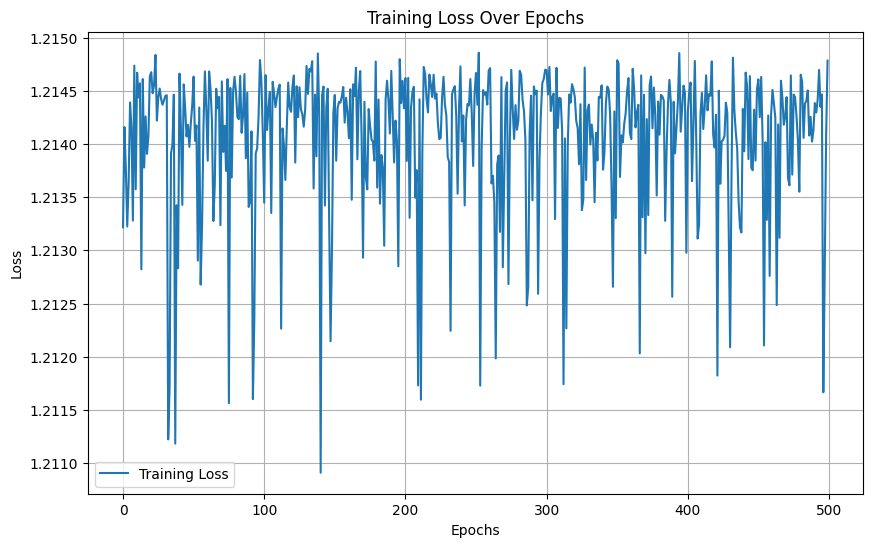

In [26]:
# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss_logger, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

# Ensure the model is in evaluation mode
weather_mlp.eval()

# Initialize lists to store predictions and targets
all_predictions = []
all_targets = []

with torch.no_grad():  # Disable gradient calculations for evaluation
    for day, month, data_seq, target_seq in tqdm(data_loader_test, desc="Testing", leave=False):
        # Move data to the device (GPU/CPU)
        seq_block = data_seq.to(device)  # (batch_size, 30, features)
        target_seq_block = target_seq.to(device)  # (batch_size, 7, features)

        # Make predictions
        data_pred = weather_mlp(seq_block)  # (batch_size, 7, features)

        # Append predictions and targets to the lists
        all_predictions.append(data_pred.cpu().numpy())
        all_targets.append(target_seq_block.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.concatenate(all_predictions, axis=0)  # (num_samples, 7, features)
all_targets = np.concatenate(all_targets, axis=0)          # (num_samples, 7, features)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(all_targets.reshape(-1, all_targets.shape[-1]),
                         all_predictions.reshape(-1, all_predictions.shape[-1]))

print(f"Test MSE: {mse:.4f}")

Test MSE: 1.1082


In [28]:
# Plot the Last 7 Days

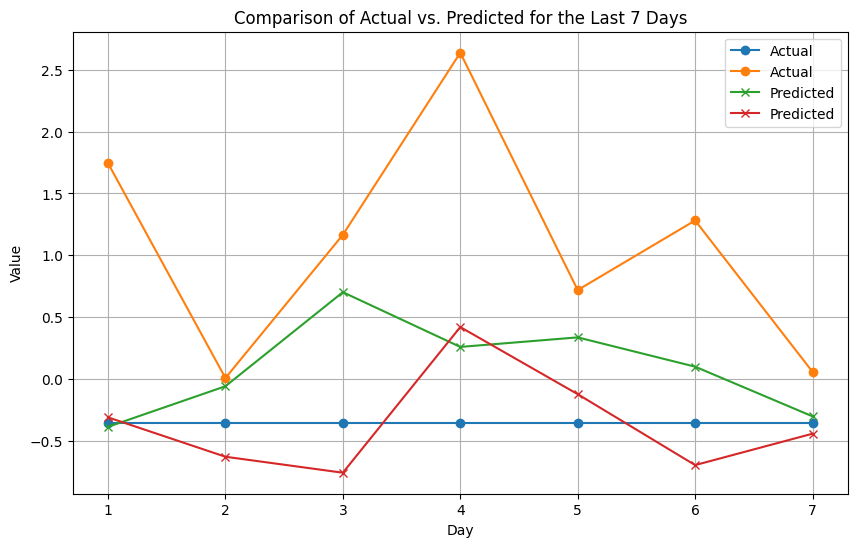

In [29]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
weather_mlp.eval()

# Get the last batch from the test DataLoader
last_batch = next(iter(DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)))
day, month, data_seq, target_seq = last_batch

# Select the last 7 days for the test set
seq_block = data_seq[:, :30].to(device)  # Input sequence for 30 days
target_seq_block = target_seq.to(device)  # Target sequence for the last 7 days

# Make predictions
with torch.no_grad():
    data_pred = weather_mlp(seq_block)  # Predict the next 7 days

# Convert tensors to numpy arrays for plotting
predicted = data_pred.cpu().numpy()[-1]  # Get the last sample's prediction
actual = target_seq_block.cpu().numpy()[-1]  # Get the last sample's actual values

# Plot the results
days = range(1, 8)  # Days 1 to 7
plt.figure(figsize=(10, 6))
plt.plot(days, actual, label="Actual", marker='o')
plt.plot(days, predicted, label="Predicted", marker='x')
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Comparison of Actual vs. Predicted for the Last 7 Days")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import numpy as np

# Ensure the model is in evaluation mode
weather_mlp.eval()

# Get the initial sequence (last 30 days from the test set)
last_30_days = dataset_test.dataset.iloc[-30:].values  # Shape: (30, features)

# Convert to tensor and move to device
seq_block = torch.FloatTensor(last_30_days).unsqueeze(0).to(device)  # Shape: (1, 30, features)

# Initialize an array to store predictions
predictions = []

# Predict 30 days sequentially
with torch.no_grad():
    for day in range(30):
        # Predict the next 7 days
        predicted_block = weather_mlp(seq_block)  # Shape: (1, 7, features)

        # Extract the prediction for the next day (first day of the predicted block)
        next_day_pred = predicted_block[:, 0, :].unsqueeze(0)  # Shape: (1, 1, features)

        # Store the next day prediction
        predictions.append(next_day_pred.cpu().numpy().squeeze())  # Shape: (features,)

        # Update the sequence for the next iteration
        seq_block = torch.cat((seq_block[:, 1:, :], next_day_pred), dim=1)  # Shape: (1, 30, features)

# Convert predictions to a numpy array
predictions = np.array(predictions)  # Shape: (30, features)

# Print or analyze the predictions
print(f"Predictions for the next 30 days: {predictions}")


Predictions for the next 30 days: [[-0.11746882  0.0308039 ]
 [-0.67561823 -0.1874545 ]
 [-0.54211944 -0.22249429]
 [ 0.14163193  0.01492157]
 [ 0.04925475  0.15800855]
 [-0.3777298  -0.41414467]
 [-0.1190943   0.19178048]
 [-0.70842946 -0.09209782]
 [-0.66527486 -0.34736913]
 [ 0.05733313  0.4106287 ]
 [-0.9759035  -0.5366081 ]
 [-0.18389033 -0.48140576]
 [ 0.02863501 -0.06581908]
 [-0.36725062 -0.19833702]
 [ 0.01336372 -0.05238229]
 [-0.3751468   0.01093824]
 [-0.5564639   0.04189735]
 [-0.13975553  0.39895564]
 [-0.09316739 -0.06675206]
 [-0.43332595 -0.21918872]
 [-0.42319864 -0.17789048]
 [-0.07158494 -0.02346982]
 [-0.23264469  0.26273242]
 [-0.75446403  0.11758468]
 [-0.14148961  0.22264326]
 [ 0.05675055  0.6065199 ]
 [-0.09919254  0.28528103]
 [-0.09396352  0.36364558]
 [-0.22324824  0.30198997]
 [ 0.05039932  0.03710629]]


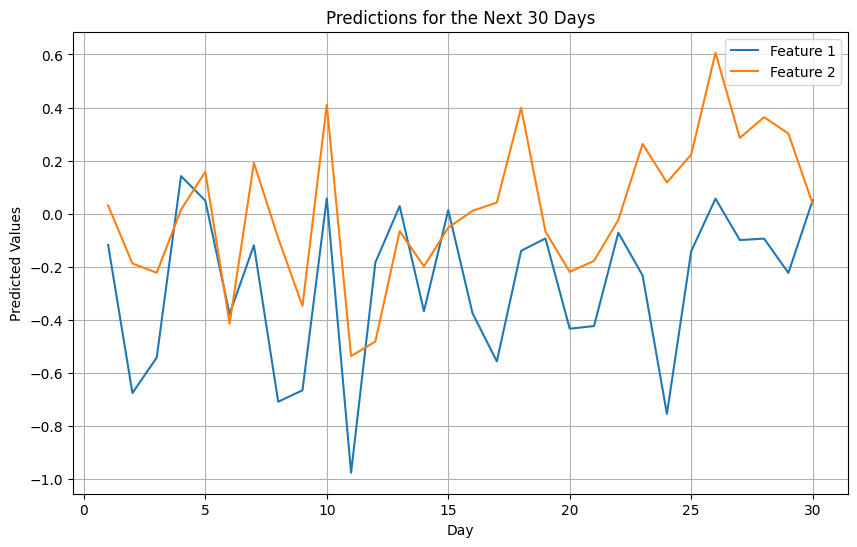

In [31]:
import matplotlib.pyplot as plt

days = range(1, 31)
plt.figure(figsize=(10, 6))
for feature_idx in range(predictions.shape[1]):
    plt.plot(days, predictions[:, feature_idx], label=f"Feature {feature_idx + 1}")

plt.xlabel("Day")
plt.ylabel("Predicted Values")
plt.title("Predictions for the Next 30 Days")
plt.legend()
plt.grid(True)
plt.show()


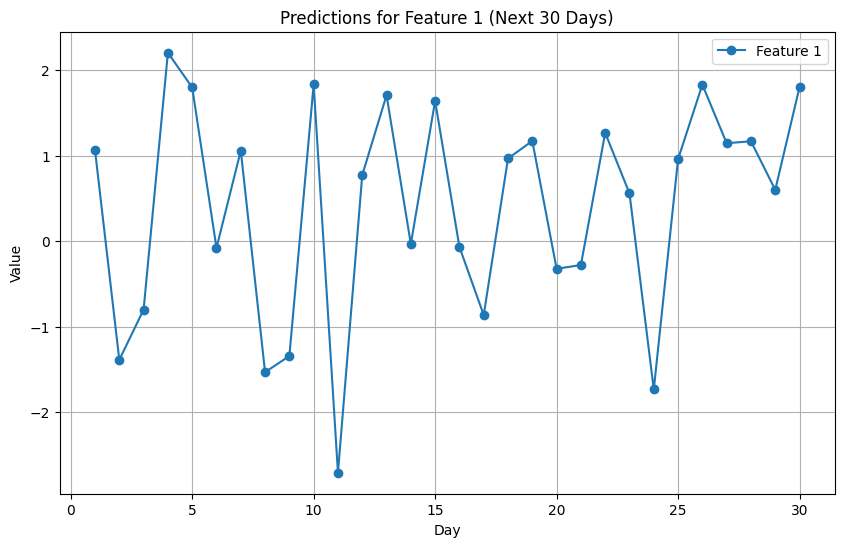

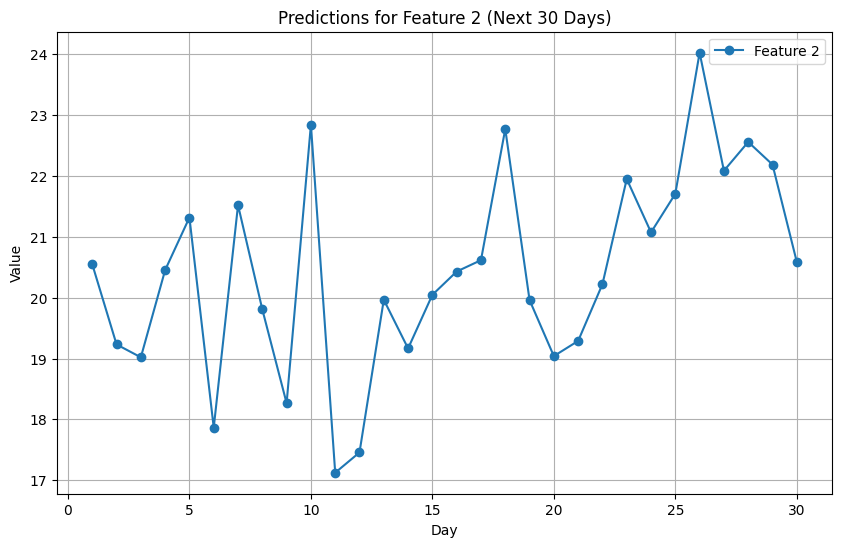

In [32]:
# Ensure the model is in evaluation mode
weather_mlp.eval()

# Get the last 30 days of actual data from the test set (normalized)
last_30_days = dataset_test.dataset.iloc[-30:].values  # Shape: (30, features)
seq_block = torch.FloatTensor(last_30_days).unsqueeze(0).to(device)  # Shape: (1, 30, features)

# Initialize an array to store predictions
predictions = []

# Predict 30 days sequentially
with torch.no_grad():
    for day in range(30):
        # Predict the next 7 days
        predicted_block = weather_mlp(seq_block)  # Shape: (1, 7, features)

        # Extract the prediction for the next day (first day of the predicted block)
        next_day_pred = predicted_block[:, 0, :].unsqueeze(0)  # Shape: (1, 1, features)

        # Store the next day prediction
        predictions.append(next_day_pred.cpu().numpy().squeeze())  # Shape: (features,)

        # Update the sequence for the next iteration
        seq_block = torch.cat((seq_block[:, 1:, :], next_day_pred), dim=1)  # Shape: (1, 30, features)

# Convert predictions to a numpy array
predictions = np.array(predictions)  # Shape: (30, features)

# Denormalize predictions
mean = dataset_test.mean.numpy().squeeze()  # Mean for each feature
std = dataset_test.std.numpy().squeeze()    # Std for each feature
predictions_original = predictions * std + mean  # Denormalized predictions

# Plot predictions for each feature
import matplotlib.pyplot as plt

days = range(1, 31)  # Days 1 to 30

for feature_idx in range(predictions_original.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(days, predictions_original[:, feature_idx], label=f"Feature {feature_idx + 1}", marker='o')
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.title(f"Predictions for Feature {feature_idx + 1} (Next 30 Days)")
    plt.legend()
    plt.grid(True)
    plt.show()


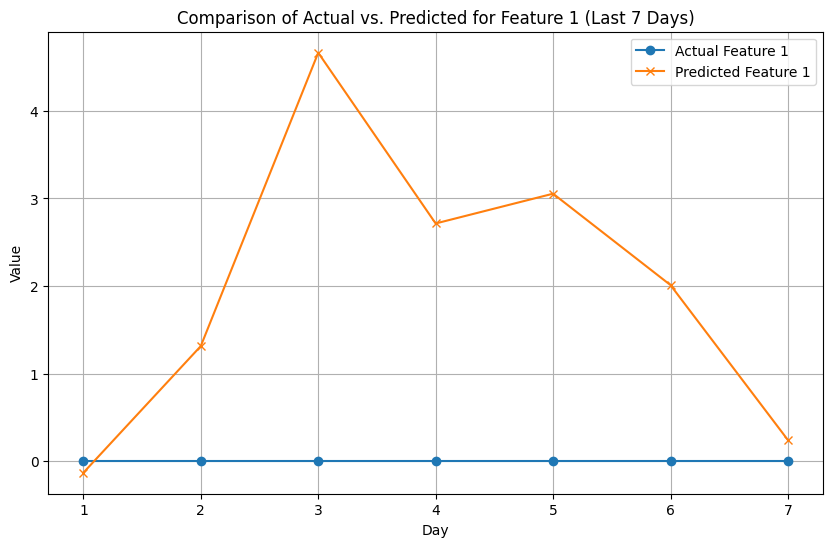

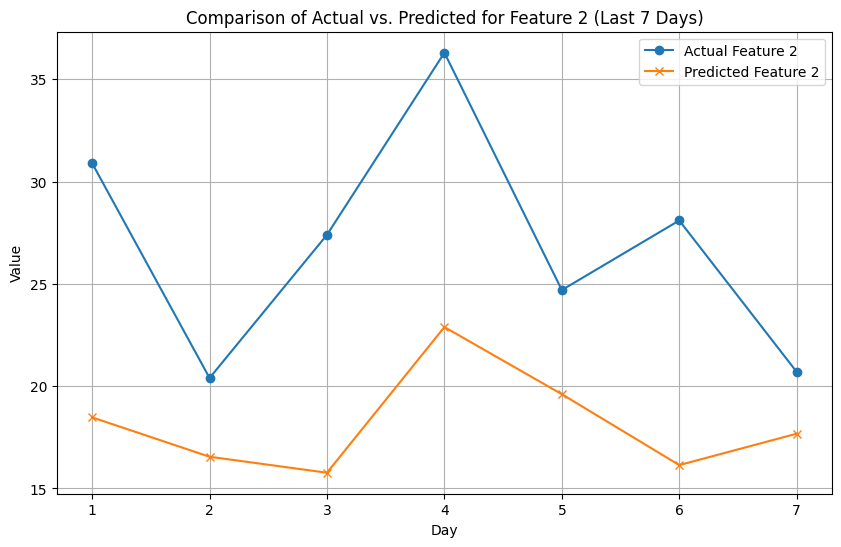

In [33]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
weather_mlp.eval()

# Get the last batch from the test DataLoader
last_batch = next(iter(DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)))
day, month, data_seq, target_seq = last_batch

# Select the last 30 days for the test set (input sequence) and the actual next 7 days (target sequence)
seq_block = data_seq[:, :30].to(device)  # Input sequence for 30 days
target_seq_block = target_seq.to(device)  # Target sequence for the next 7 days

# Make predictions
with torch.no_grad():
    data_pred = weather_mlp(seq_block)  # Predict the next 7 days

# Denormalize predictions and actual values
mean = dataset_test.mean.numpy().squeeze()  # Mean for each feature
std = dataset_test.std.numpy().squeeze()    # Std for each feature

predicted = (data_pred.cpu().numpy() * std + mean)[-1]  # Denormalized prediction for the last sample
actual = (target_seq_block.cpu().numpy() * std + mean)[-1]  # Denormalized actual values for the last sample

# Plot the results for each feature
days = range(1, 8)  # Days 1 to 7
for feature_idx in range(predicted.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(days, actual[:, feature_idx], label=f"Actual Feature {feature_idx + 1}", marker='o')
    plt.plot(days, predicted[:, feature_idx], label=f"Predicted Feature {feature_idx + 1}", marker='x')
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.title(f"Comparison of Actual vs. Predicted for Feature {feature_idx + 1} (Last 7 Days)")
    plt.legend()
    plt.grid(True)
    plt.show()


## test datasets